# Actor Criticの考え方を迷路問題を用いて確認する
* Actor Critic法は、方策と状態価値を独立に扱うTD学習法  
    * 方策が価値関数から独立しているため、方策を任意に拡張することが可能  
    * 方策に連続分布を用いれば、連続値行動タスクにおいても、効率的に行動探索を行える
    * 方策を陽に表現できるため、学習によって求めた方策からいろんな考察を行うことができる
* Actor Critic法は、汎用的な考え方であり、いろんな実装が考えられる
    * ここでは、1つの例として、Actorの方策にソフトマックス関数を用いた例を紹介する


In [1]:
import numpy as np
from collections import defaultdict
from common.agent import CommonAgent
from common.show_value import show_q_value,show_v_value
from common.meiro import Environment

In [2]:
class Actor(CommonAgent):
    """
    Actor(戦略担当)のクラス
    """
    def __init__(self, env):
        # CommonAgentクラスの__init__メソッドを実行する
        super().__init__(epsilon=-1)
        
        nrow = env.row_length
        ncol = env.col_length
        self.actions = env.actions
        num_actions = len(self.actions)
        
        # 0-1のランダム値で初期化
        self.Q = defaultdict(lambda: [0] * num_actions) # 行動価値
        for s in env.states:
            if env.grid[s.row, s.col]==0:
                """
                通常セルにだけ行動価値を割り当てる
                """
                self.Q[s] = np.random.uniform(0, 1, size=num_actions)

    def softmax(self, x):
        """
        ソフトマックス関数
        """
        return np.exp(x) / np.sum(np.exp(x))

    def policy(self, s):
        """
        方策関数
        """
        # 行動価値に基づいて、確率的に行動を選択する
        prob = self.softmax(self.Q[s])
        return np.random.choice(self.actions, size=1, p=prob)


class Critic():
    """
    Critic(評価担当)のクラス
    """
    def __init__(self, env):
        states = env.states

        # 0で初期化
        self.V = defaultdict(lambda:0) # 状態価値
        for s in env.states:
            self.V[s] = 0
            

class ActorCriticAgent():
    """
    ActorCritic法によって行動価値を更新するためのエージェントクラス
    """
    
    def __init__(self, actor_class, critic_class):
        self.actor_class = actor_class
        self.critic_class = critic_class
   
    def learn(self, env, episode_num=1000, gamma=0.9, report_interval=50, alpha=0.01):
        """
        学習を実行するメソッド
        episode_num : エピソード数
        gamma : 割引率
        report_interval : 結果を表示させる間隔
        alpha : 学習率
        """
        
        # 初期化
        actor = self.actor_class(env)
        critic = self.critic_class(env)
        actor.init_log()
        
        # エピソードのループ
        for e in range(episode_num):
            
            # 初期化
            s = env.reset()
            done = False
            
            # 1エピソードを実行
            while not done:

                # actorの方策に基づいて、行動をとる
                a = actor.policy(s)
                next_state, reward, done = env.step(a)

                # TD誤差を求める
                gain = reward + gamma * critic.V[next_state]
                estimated = critic.V[s]
                td = gain - estimated # 状態価値の最適化を目指す
                
                # actorの行動価値Qを更新する
                actor.Q[s][a] += alpha * td
                
                # criticの状態価値Vを更新する
                critic.V[s] += alpha * td
                
                # 状態を更新する
                s = next_state


            # 最後の報酬を記録しておく
            actor.log(reward)

            # 報酬を表示する
            if e != 0 and e % report_interval == 0:
                actor.show_rewards_log(episode=e)

        return actor, critic

## 実行

In [3]:
# 迷路の条件を設定する
grid = np.array([[0,0,0,0],[0,-1,0,-1],[0,0,0,-1],[-1,0,0,1]])

# 環境をつくる
env = Environment(grid, move_prob=0.95, agent_init_state=(0,0))

# エージェントをつくる
agent = ActorCriticAgent(Actor, Critic)

# 学習の実行
actor, critic = agent.learn(env, gamma=0.9,  episode_num=500, alpha=0.5)

At Episode 50 average reward is -0.56 (+/-0.828).
At Episode 100 average reward is 0.56 (+/-0.828).
At Episode 150 average reward is 0.8 (+/-0.6).
At Episode 200 average reward is 0.84 (+/-0.543).
At Episode 250 average reward is 0.84 (+/-0.543).
At Episode 300 average reward is 0.76 (+/-0.65).
At Episode 350 average reward is 0.88 (+/-0.475).
At Episode 400 average reward is 0.84 (+/-0.543).
At Episode 450 average reward is 0.88 (+/-0.475).


## 結果の可視化

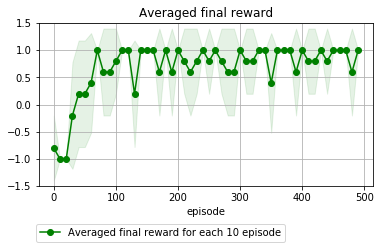

In [4]:
# agent.rewards_logに保存している各エピソードの最終報酬額を可視化する
# 全エピソードを表示させると傾向を捉えにくくなるため、10エピソード毎に平均をとっている
# 学習が進むと、エージェントはゴールできるようになってくるため、値は1(ゴール時の報酬)に近づく
actor.show_rewards_log(interval=10)

* Q学習やSARSAにくらべ、学習率を大きくしても安定して高い報酬を得られることがわかる

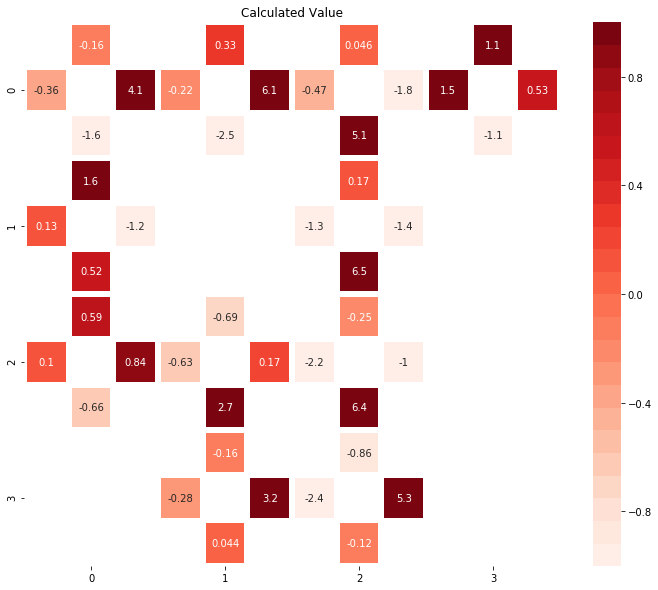

In [5]:
# 学習によって求めた行動価値Qを可視化する
# 行動価値は、通常セル毎に4つの値(UP,DOEN,LEFT,RIGTH)を持っている
# 以下のグラフでは、通常セルを中心に、上下左右の4つのセルに値を配置した
show_q_value(actor.Q, row=grid.shape[0], col=grid.shape[1])    

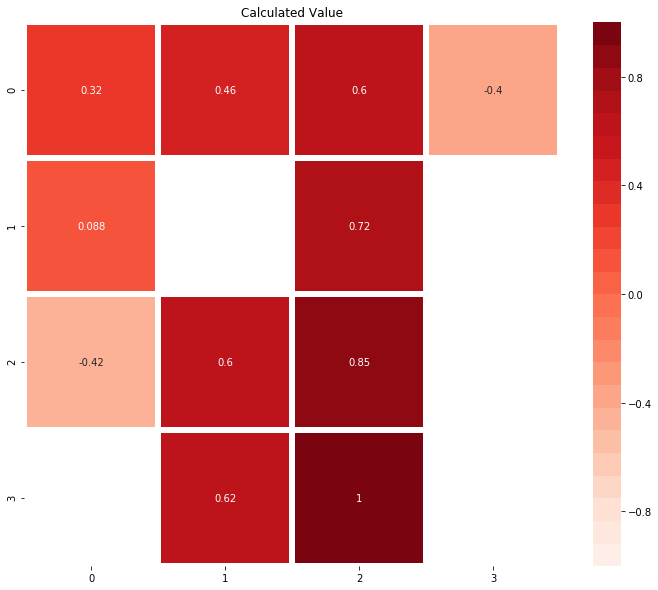

In [6]:
# 学習によって求めた状態価値Vを可視化する
# 状態価値は、通常セル毎に1つの値を持っている
show_v_value(critic.V, row=grid.shape[0], col=grid.shape[1])        

### [演習]
* grid条件、エージェントの初期位置、alphaなどを変更して、学習の進み具合を確認しましょう